<a href="https://colab.research.google.com/github/Ddkaba/IAD_Lab_1/blob/main/IAD_Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.svm import SVC

import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import itertools
from tensorflow.keras import regularizers

In [ ]:
dataset = pd.read_csv("https://raw.githubusercontent.com/Ddkaba/IAD_Lab_1/main/V2.csv", index_col=0)
if 'No' in dataset.columns:
    dataset = dataset.drop(columns=['No'])

In [24]:
# ### BEGIN YOUR CODE
print("Общая информация")
print(dataset.info())

print(f"Количество записей (объектов): {dataset.shape[0]}")
print(f"Количество признаков (фич): {dataset.shape[1]}")

print("\nНазвания столбцов:")
print(dataset.columns.tolist())

print("\nТипы данных:")
print(dataset.dtypes)

print("\nПропущенные значения:")
missing_values = dataset.isnull().sum()
print(missing_values)
print(f"Общее количество пропущенных значений: {missing_values.sum()}")

print("Целевая переменная")
target_column = 'Y house price of unit area'
if target_column in dataset.columns:
    print(f"\nЦелевая переменная: {target_column}")
    print(f"Тип данных целевой переменной: {dataset[target_column].dtype}")
    unique_values = dataset[target_column].unique()
    print(f"Уникальные значения целевой переменной (первые 20): {unique_values[:20]}")
    print(f"Всего уникальных значений: {unique_values.size}")
    if dataset[target_column].nunique() <= 20:
        print("Распределение классов:")
        print(dataset[target_column].value_counts())
        print("Процентное соотношение классов:")
        print(dataset[target_column].value_counts(normalize=True) * 100)

print("Статистика")
print(dataset.describe())

print("Анализ кат. признаков")
categorical_features = []
for col in dataset.columns:
    unique_values = dataset[col].nunique(dropna=True)
    if unique_values <= 10:
        categorical_features.append(col)
        print(f"{col}: {unique_values} уникальных значений - {dataset[col].unique()}")

print(f"\nВсего категориальных признаков: {len(categorical_features)}")

print("Корреляции признаков с целевой переменной:")
if target_column in corr_matrix.columns:
    print(corr_matrix[target_column].sort_values(ascending=False))
# ### END YOUR CODE


Общая информация
<class 'pandas.core.frame.DataFrame'>
Index: 414 entries, 0 to 413
Data columns (total 7 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   X1 transaction date                     414 non-null    float64
 1   X2 house age                            205 non-null    float64
 2   X3 distance to the nearest MRT station  414 non-null    float64
 3   X4 number of convenience stores         414 non-null    int64  
 4   X5 latitude                             414 non-null    float64
 5   X6 longitude                            414 non-null    float64
 6   Y house price of unit area              414 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 25.9 KB
None
Количество записей (объектов): 414
Количество признаков (фич): 7

Названия столбцов:
['X1 transaction date', 'X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 l

Данный датасет — таблица с данными о 414 домах, описанных по 7 признакам.
Главная цель — предсказать цену за единицу площади (столбец Y house price of unit area, тип float64), которая варьируется от 7.6 до 117.5 с медианой 38.45, это говорит о большом разбросе цен. Столбцы включают: дату сделки (X1 transaction date, float64, 2012–2013 годы, среднее 2013.15,
разброс небольшой), возраст дома (X2 house age, float64, среднее 18.2 года, от 0 до 43.8 лет),
расстояние до ближайшей станции метро (X3 distance to the nearest MRT station, float64, среднее 1084 м, от 23 до 6488 м),
количество магазинов поблизости (X4 number of convenience stores, int64, среднее 4, от 0 до 10), широту (X5 latitude, float64, среднее 24.969, диапазон 24.932–25.015) и
долготу (X6 longitude, float64, среднее 121.533, диапазон 121.474–121.566). Пропуски есть только в возрасте дома, остальные столбцы заполнены полностью.
Категориальных признаков нет, все данные числовые.
Пропуски в возрасте дома — главная проблема, их нужно либо заполнить, либо исключить этот признак.
Сильная положительная корреляция с ценой наблюдается для количества магазинов поблизости (X4, 0.57), что указывает на то, что больше магазинов вокруг — выше цена,
а также для широты (X5, 0.55) и долготы (X6, 0.52), намекающих на влияние престижности определённых районов, тогда как дата сделки (X1, 0.09) почти не влияет.
Сильная отрицательная корреляция видна с расстоянием до метро (X3, -0.67) — чем дальше до станции, тем ниже цена.
Это значит, что цена на дома больше всего зависит от близости к метро и наличия магазинов — чем ближе метро и больше магазинов, тем дороже жильё,
а географическое положение тоже играет роль, возможно, отражая престижность района, тогда как возраст дома и дата сделки влияют слабо,
что может быть связано с узким периодом данных (2012–2013) и пропусками в X2 house age.

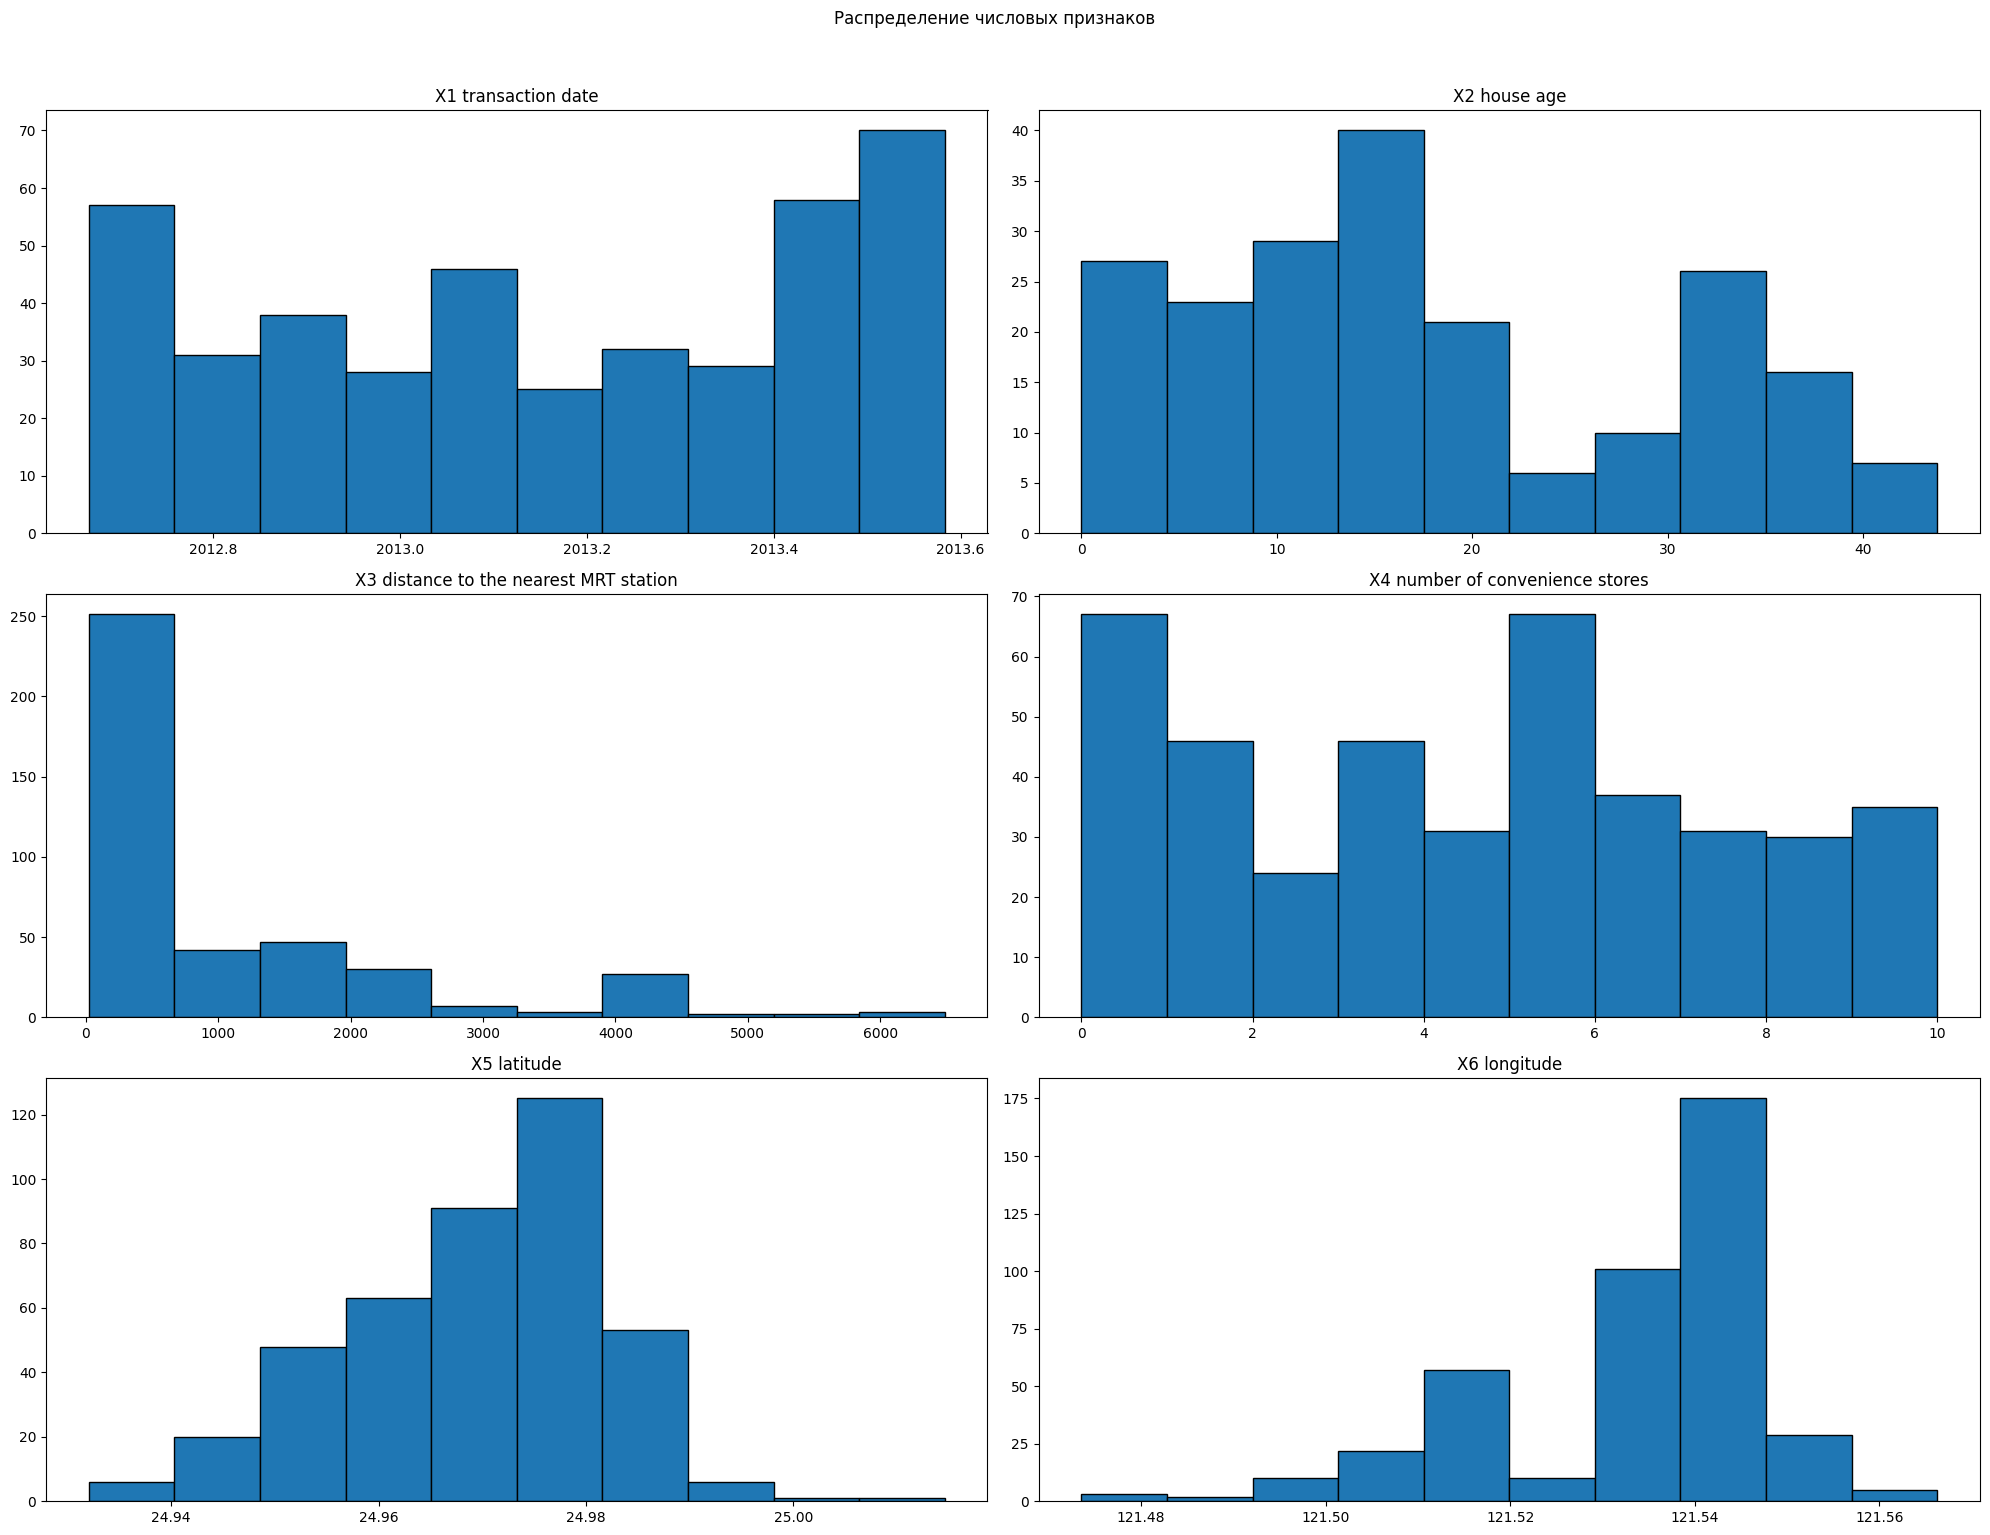

In [ ]:
# ### BEGIN YOUR CODE
# Гистограммы по всем числовым признакам (без целевой)
# Определим список числовых колонок и исключим целевую, если она есть
feature_columns = dataset.select_dtypes(include=[np.number]).columns.tolist()
if 'Y house price of unit area' in feature_columns:
    feature_columns.remove('Y house price of unit area')

_ = dataset[feature_columns].hist(
    bins=10,
    figsize=(20, 15),
    grid=False,
    edgecolor='black'
)
plt.suptitle('Распределение числовых признаков', y=1.02)
plt.tight_layout()
plt.show()
# ### END YOUR CODE


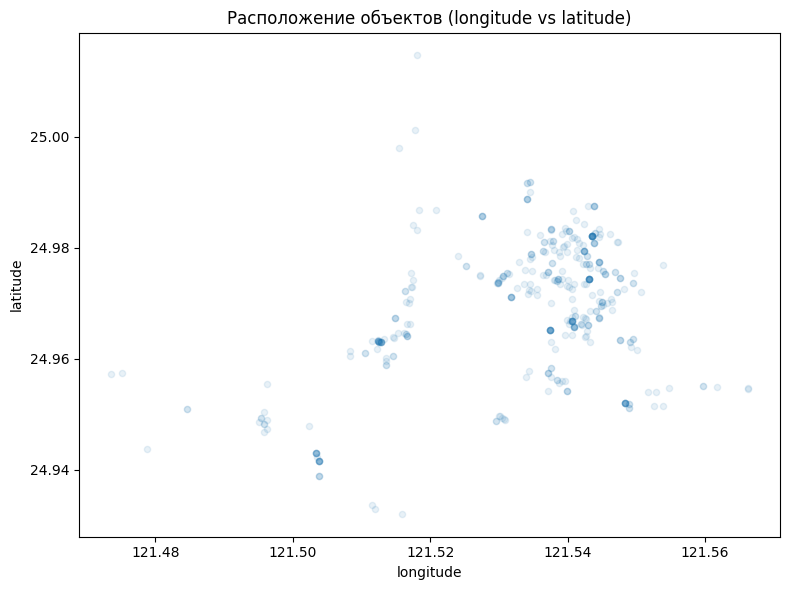

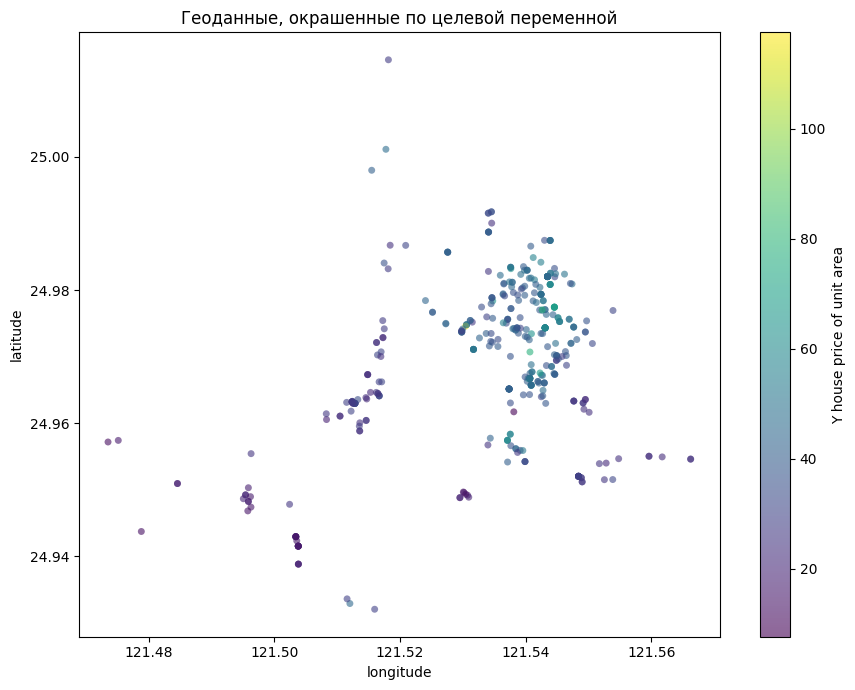

In [ ]:
# ### BEGIN YOUR CODE
# Геовизуализация: долгота vs широта
lon_col = 'X6 longitude'
lat_col = 'X5 latitude'

# Базовый scatter, как на слайде
ax = dataset.plot(kind='scatter', x=lon_col, y=lat_col, alpha=0.1, figsize=(8, 6))
ax.set_title('Расположение объектов (longitude vs latitude)')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
plt.tight_layout()
plt.show()

# Раскраска по целевой (если есть)
if 'Y house price of unit area' in dataset.columns:
    plt.figure(figsize=(9, 7))
    sc = plt.scatter(
        dataset[lon_col], dataset[lat_col],
        c=dataset['Y house price of unit area'], cmap='viridis',
        s=25, alpha=0.6, edgecolors='none'
    )
    cbar = plt.colorbar(sc)
    cbar.set_label('Y house price of unit area')
    plt.title('Геоданные, окрашенные по целевой переменной')
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.tight_layout()
    plt.show()
# ### END YOUR CODE


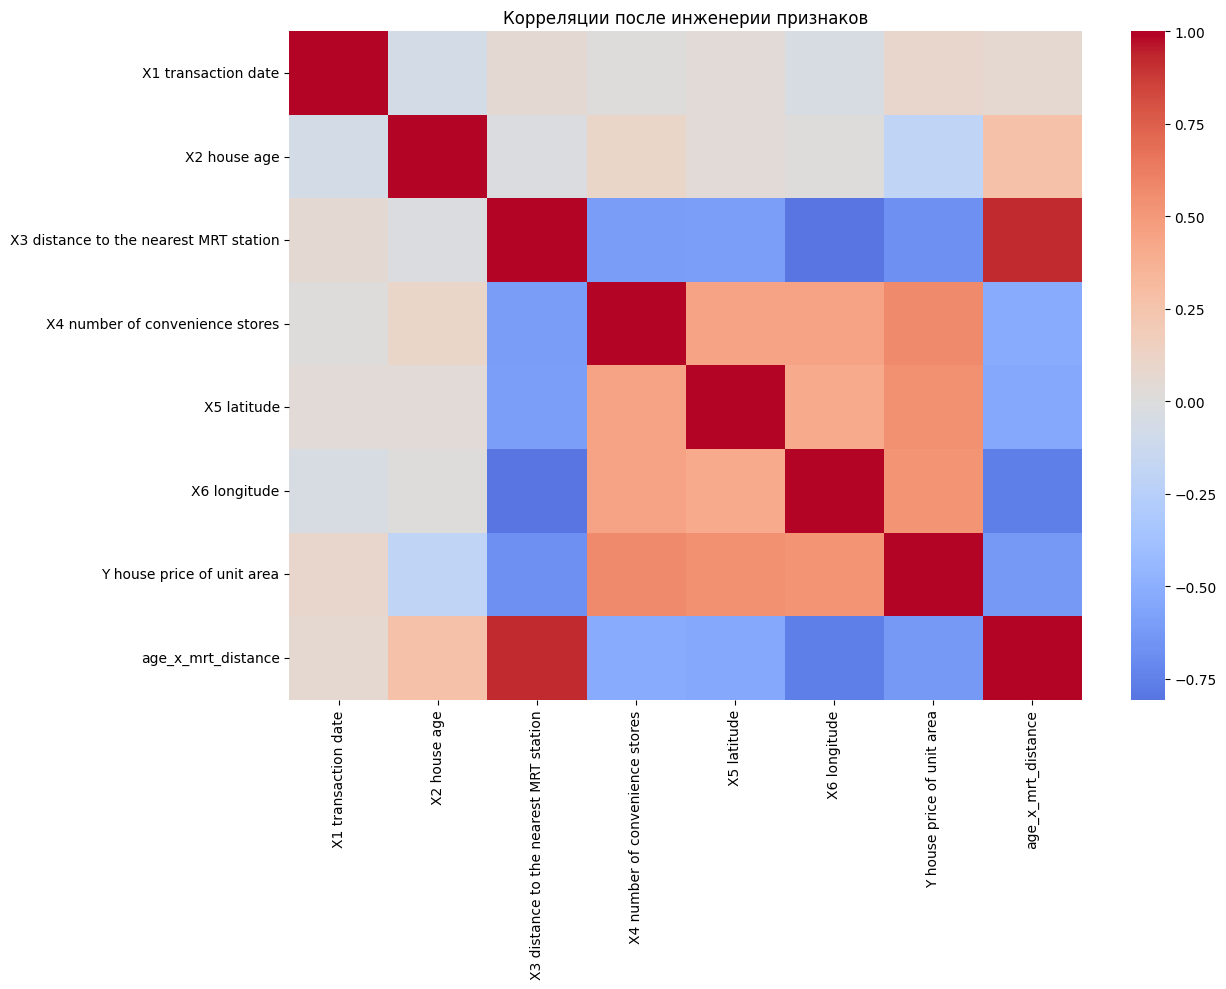


Топ-15 корреляций с целевой:
Y house price of unit area                1.000000
X4 number of convenience stores           0.571005
X5 latitude                               0.546307
X6 longitude                              0.523287
X1 transaction date                       0.087491
X2 house age                             -0.195321
age_x_mrt_distance                       -0.629185
X3 distance to the nearest MRT station   -0.673613
Name: Y house price of unit area, dtype: float64


In [ ]:
# ### BEGIN YOUR CODE
# Эксперименты с комбинациями атрибутов + пересчет корреляций
TARGET = 'Y house price of unit area'

dataset_fe = dataset.copy()

df_original = dataset.copy()

# 1) Взаимодействие возраста. Старый и далёкий объект «штрафуется» сильнее, новый рядом со станцией — «премируется». Это даёт модели не одну общую «цену километра», а разную в зависимости от возраста.
age_med = dataset_fe['X2 house age'].median()
age_filled_tmp = dataset_fe['X2 house age'].fillna(age_med)
dataset_fe['age_x_mrt_distance'] = age_filled_tmp * dataset_fe['X3 distance to the nearest MRT station']

df_engineered = dataset_fe.copy()

# Корреляции
corr = dataset_fe.corr(numeric_only=True)
plt.figure(figsize=(13, 10))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Корреляции после инженерии признаков')
plt.tight_layout()
plt.show()

if TARGET in corr.columns:
    print('\nТоп-15 корреляций с целевой:')
    print(corr[TARGET].sort_values(ascending=False).head(15))
# ### END YOUR CODE


Медиана X2 house age: 16.200
Пропусков до/после: 209 -> 0


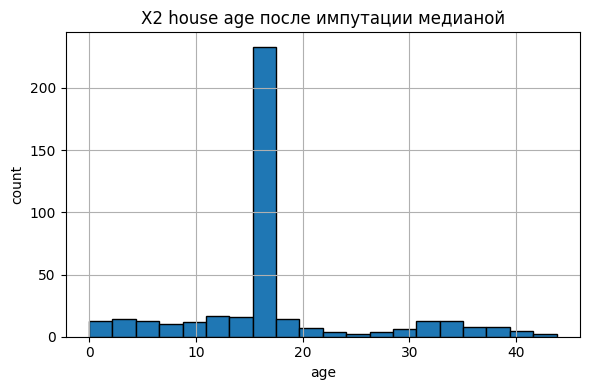

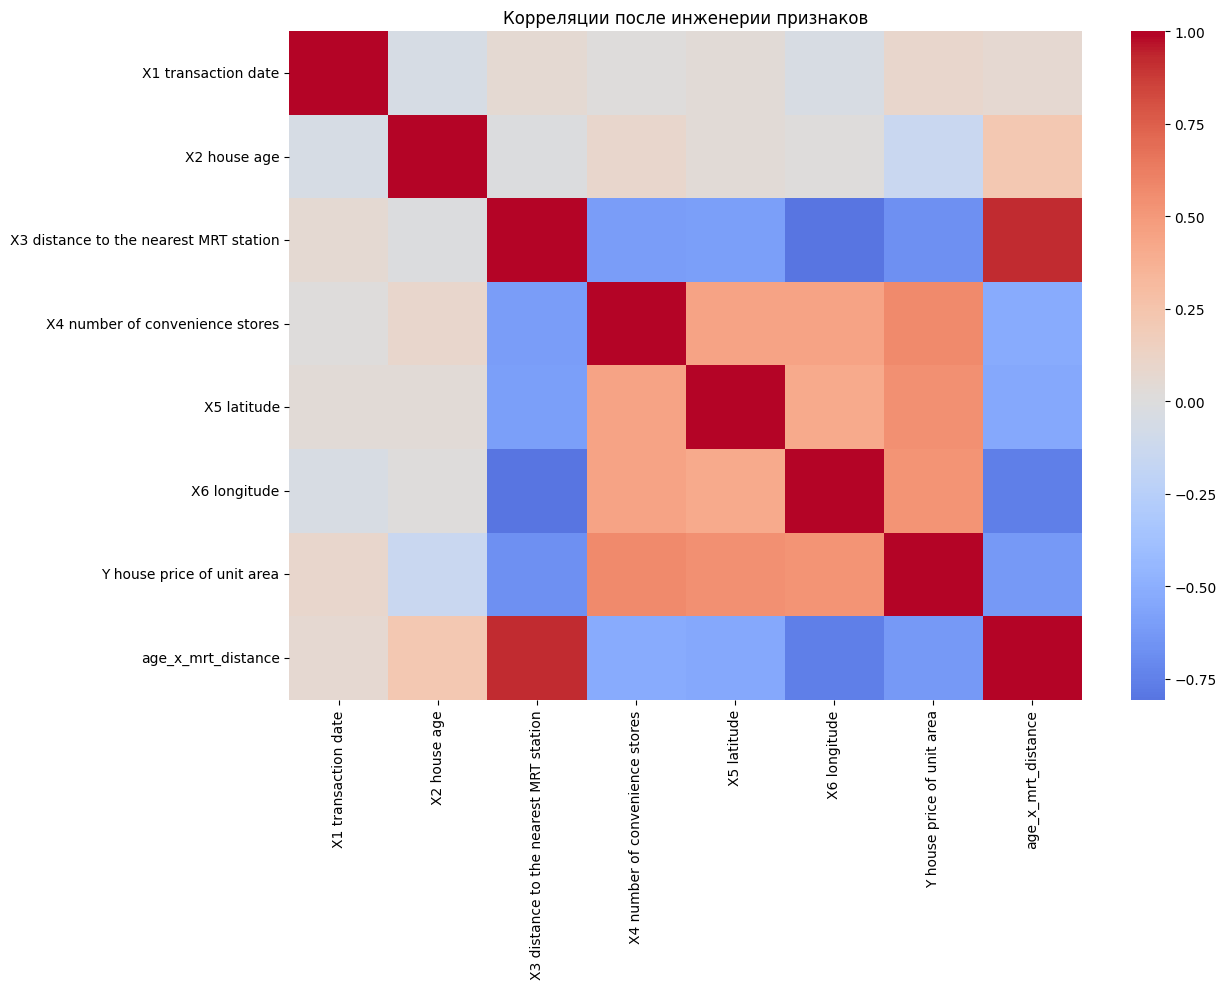


Топ-15 корреляций с целевой:
Y house price of unit area                1.000000
X4 number of convenience stores           0.571005
X5 latitude                               0.546307
X6 longitude                              0.523287
X1 transaction date                       0.087491
X2 house age                             -0.143517
age_x_mrt_distance                       -0.629185
X3 distance to the nearest MRT station   -0.673613
Name: Y house price of unit area, dtype: float64


In [ ]:
# ### BEGIN YOUR CODE
# Импутация пропусков в X2 house age медианой + контроль результата

df_original_preprocessed = dataset.copy()

col = 'X2 house age'
med = dataset_fe[col].median()
missing_before = dataset_fe[col].isna().sum()

dataset_fe[col] = dataset_fe[col].fillna(med)
missing_after = dataset_fe[col].isna().sum()

med2 = df_original_preprocessed[col].median()
df_original_preprocessed[col] = df_original_preprocessed[col].fillna(med2)

print(f"Медиана {col}: {med:.3f}")
print(f"Пропусков до/после: {missing_before} -> {missing_after}")

# Визуальная проверка распределения после импутации
plt.figure(figsize=(6, 4))
dataset_fe[col].hist(bins=20, edgecolor='black')
plt.title(f'{col} после импутации медианой')
plt.xlabel('age')
plt.ylabel('count')
plt.tight_layout()
plt.show()

# Корреляции
corr = dataset_fe.corr(numeric_only=True)
plt.figure(figsize=(13, 10))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Корреляции после инженерии признаков')
plt.tight_layout()
plt.show()

if TARGET in corr.columns:
    print('\nТоп-15 корреляций с целевой:')
    print(corr[TARGET].sort_values(ascending=False).head(15))
# ### END YOUR CODE

Оценки информативности (f_regression), по убыванию:
                                  feature       score
0  X3 distance to the nearest MRT station  342.239318
1                      age_x_mrt_distance  269.977275
2         X4 number of convenience stores  199.318238
3                             X5 latitude  175.271845
4                            X6 longitude  155.359301
5                            X2 house age    8.664463
6                     X1 transaction date    3.178024


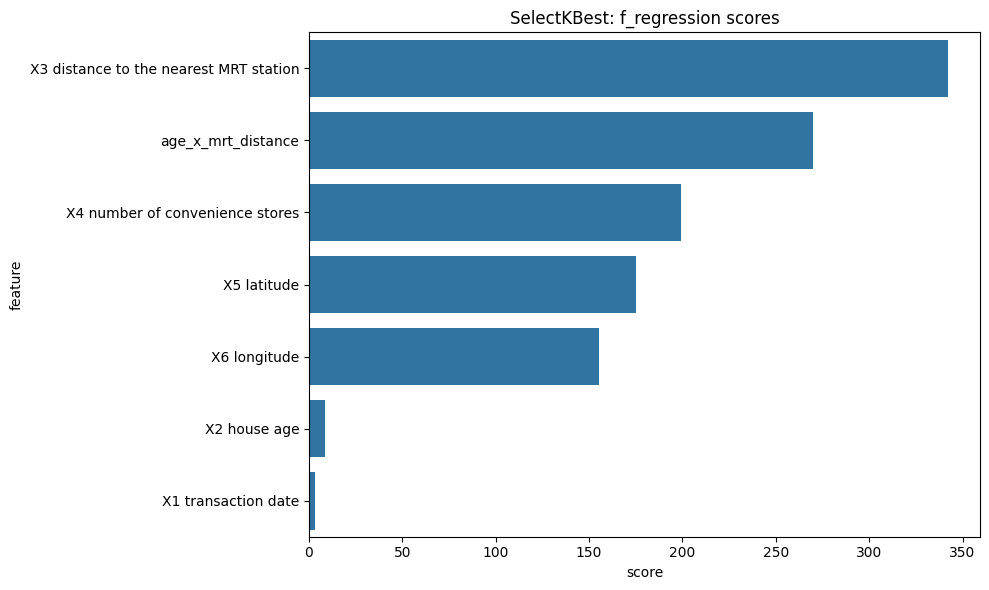

Топ-5 признаков:
['X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 latitude', 'X6 longitude', 'age_x_mrt_distance']


In [ ]:
# ### BEGIN YOUR CODE
# SelectKBest (f_regression): оценка информативности признаков и выбор ТОП-5


TARGET = 'Y house price of unit area'

# Берём расширенный набор, если он уже посчитан; иначе — исходный
source_df = dataset_fe if 'dataset_fe' in globals() else dataset

# Числовые признаки
X_num = source_df.drop(columns=[TARGET]).select_dtypes(include=[np.number])
y = source_df[TARGET]

# Импутация оставшихся пропусков медианой (на всякий случай)
imputer = SimpleImputer(strategy='median')
X_num_imp = pd.DataFrame(imputer.fit_transform(X_num), columns=X_num.columns, index=X_num.index)

# 1) Считаем баллы для всех фич
all_selector = SelectKBest(score_func=f_regression, k='all')
all_selector.fit(X_num_imp, y)

scores_df = (
    pd.DataFrame({'feature': X_num_imp.columns, 'score': all_selector.scores_})
      .sort_values('score', ascending=False)
      .reset_index(drop=True)
)
print('Оценки информативности (f_regression), по убыванию:')
print(scores_df)

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(data=scores_df, x='score', y='feature', color='#1f77b4')
plt.title('SelectKBest: f_regression scores')
plt.tight_layout()
plt.show()

# 2) Выбор ТОП-K признаков
K = 5
selector = SelectKBest(score_func=f_regression, k=K)
selector.fit(X_num_imp, y)
selected_features = X_num_imp.columns[selector.get_support()].tolist()
print(f'Топ-{K} признаков:')
print(selected_features)
# ### END YOUR CODE


In [ ]:
# ### BEGIN YOUR CODE
# Удаление нерелевантных признаков, как на слайде
cols_to_drop = ['X2 house age', 'X1 transaction date']

# Работаем с расширенным набором, если он есть; иначе — с исходным
df_ref = dataset_fe if 'dataset_fe' in globals() else dataset

print('До:', df_ref.shape)
df_ref.drop(columns=[c for c in cols_to_drop if c in df_ref.columns], axis=1, inplace=True)
print('После:', df_ref.shape)
print('Текущие столбцы:')
print(df_ref.columns.tolist())

# Если работали с исходным датасетом, синхронизируем переменную
if 'dataset_fe' not in globals():
    dataset = df_ref
# ### END YOUR CODE


До: (414, 8)
После: (414, 6)
Текущие столбцы:
['X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 latitude', 'X6 longitude', 'Y house price of unit area', 'age_x_mrt_distance']


In [ ]:
# ### BEGIN YOUR CODE
# Стандартизация числовых признаков (z = (x - mean) / std)
TARGET = 'Y house price of unit area'

# Базовый датафрейм для трансформации: используем расширенный, если есть
base_df = dataset_fe if 'dataset_fe' in globals() else dataset

# Отбираем числовые признаки, исключая целевую
feature_cols = base_df.select_dtypes(include=[np.number]).columns.tolist()
if TARGET in feature_cols:
    feature_cols.remove(TARGET)

scaler = StandardScaler()
scaled = scaler.fit_transform(base_df[feature_cols])
standardized_df = pd.DataFrame(scaled, columns=feature_cols, index=base_df.index)

# Сохраняем предобработанные варианты
df_engineered_preprocessed = standardized_df.join(base_df[[TARGET]])

print('Стандартизированы признаки:', feature_cols)
print('Форма:', standardized_df.shape)
print(standardized_df.head())

# Быстрая проверка средних и СКО (должны быть ~0 и ~1)
means = standardized_df.mean().round(4)
stdevs = standardized_df.std(ddof=0).round(4)
print('\nСредние по столбцам (ожид. ≈ 0):')
print(means)
print('\nСт. отклонения (ожид. ≈ 1):')
print(stdevs)
# ### END YOUR CODE


Стандартизированы признаки: ['X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 latitude', 'X6 longitude', 'age_x_mrt_distance']
Форма: (414, 5)
   X3 distance to the nearest MRT station  X4 number of convenience stores  \
0                               -0.792495                         2.007407   
1                               -0.616612                         1.667503   
2                               -0.414015                         0.307885   
3                               -0.414015                         0.307885   
4                               -0.549997                         0.307885   

   X5 latitude  X6 longitude  age_x_mrt_distance  
0     1.125430      0.448762           -0.649820  
1     0.912444      0.401139           -0.515397  
2     1.486860      0.688183           -0.386616  
3     1.486860      0.688183           -0.386616  
4     0.834188      0.592937           -0.681269  

Средние по столбцам (ожид. ≈ 0):
X3 distance to t

In [ ]:
# ### BEGIN YOUR CODE
# Train/Validation/Test split: 60% / 20% / 20%

TARGET = 'Y house price of unit area'

# Источник данных: используем расширенный набор, если он уже есть
src = dataset_fe if 'dataset_fe' in globals() else dataset

X = src.drop(columns=[TARGET])
y = src[TARGET]

# 1) Test split (20%)
seed = 42
test_size = 0.2
val_size = 0.25  # 25% от train -> итог 60/20/20

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=seed
)

# 2) Validation split из обучающей части
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=val_size, random_state=seed
)

print('Shapes:')
print('X_train:', X_train.shape, 'X_val:', X_val.shape, 'X_test:', X_test.shape)
print('y_train:', y_train.shape, 'y_val:', y_val.shape, 'y_test:', y_test.shape)

print('\nX_train head:')
print(X_train.head())
print('\nX_val head:')
print(X_val.head())
print('\nX_test head:')
print(X_test.head())

print('\ny_train head:')
print(y_train.head())
print('\ny_val head:')
print(y_val.head())
print('\ny_test head:')
print(y_test.head())
# ### END YOUR CODE


Shapes:
X_train: (248, 5) X_val: (83, 5) X_test: (83, 5)
y_train: (248,) y_val: (83,) y_test: (83,)

X_train head:
     X3 distance to the nearest MRT station  X4 number of convenience stores  \
388                               2251.9380                                4   
149                                179.4538                                8   
269                                837.7233                                0   
307                               3079.8900                                0   
324                               1712.6320                                2   

     X5 latitude  X6 longitude  age_x_mrt_distance  
388     24.95957     121.51353         23420.15520  
149     24.97349     121.54245          6262.93762  
269     24.96334     121.54767         14743.93008  
307     24.95460     121.56627         31722.86700  
324     24.96412     121.51670         27744.63840  

X_val head:
     X3 distance to the nearest MRT station  X4 number of convenience sto

In [ ]:
# ### BEGIN YOUR CODE
# Сравнение MLP и простой RNN на train/val для исходного и инженерного наборов
keras = tf.keras

np.random.seed(42)
try:
    tf.random.set_seed(42)
except Exception:
    pass

TARGET = 'Y house price of unit area'

# Проверим, что разбиение уже сделано (из предыдущей ячейки)
assert 'X_train' in globals() and 'X_val' in globals(), 'Сначала запустите ячейку с train/val/test split.'
train_idx = X_train.index
val_idx = X_val.index

# Подготовим словарь наборов
datasets_map = {}
datasets_map['original'] = dataset.copy()
if 'dataset_fe' in globals():
    datasets_map['engineered'] = dataset_fe.copy()

results = []

for name, df in datasets_map.items():
    # берем только числовые признаки
    X_all = df.drop(columns=[TARGET]).select_dtypes(include=[np.number])
    y_all = df[TARGET]

    # одинаковые индексы разбиения
    X_tr = X_all.loc[train_idx]
    y_tr = y_all.loc[train_idx]
    X_va = X_all.loc[val_idx]
    y_va = y_all.loc[val_idx]

    # Импутация по train и стандартизация по train
    imputer = SimpleImputer(strategy='median')
    scaler = StandardScaler()

    X_tr_imp = imputer.fit_transform(X_tr)
    X_va_imp = imputer.transform(X_va)

    X_tr_std = scaler.fit_transform(X_tr_imp)
    X_va_std = scaler.transform(X_va_imp)

    input_dim = X_tr_std.shape[1]

    # 1) Полносвязная регрессионная модель (MLP)
    mlp = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    mlp.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse')
    es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    mlp.fit(X_tr_std, y_tr.values, validation_data=(X_va_std, y_va.values),
            epochs=300, batch_size=32, verbose=0, callbacks=[es])

    y_tr_pred = mlp.predict(X_tr_std, verbose=0).ravel()
    y_va_pred = mlp.predict(X_va_std, verbose=0).ravel()
    rmse_tr = float(np.sqrt(mean_squared_error(y_tr, y_tr_pred)))
    r2_tr = float(r2_score(y_tr, y_tr_pred))
    rmse_va = float(np.sqrt(mean_squared_error(y_va, y_va_pred)))
    r2_va = float(r2_score(y_va, y_va_pred))
    results.append({'dataset': name, 'model': 'MLP', 'rmse_train': rmse_tr, 'r2_train': r2_tr, 'rmse_val': rmse_va, 'r2_val': r2_va})

    # 2) Простая рекуррентная сеть для регрессии (SimpleRNN)
    # Представим признаки как одношаговую последовательность длиной input_dim
    X_tr_seq = X_tr_std.reshape((-1, input_dim, 1))
    X_va_seq = X_va_std.reshape((-1, input_dim, 1))

    rnn = keras.Sequential([
        layers.Input(shape=(input_dim, 1)),
        layers.SimpleRNN(32, activation='tanh'),
        layers.Dense(1)
    ])
    rnn.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse')
    es2 = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    rnn.fit(X_tr_seq, y_tr.values, validation_data=(X_va_seq, y_va.values),
            epochs=300, batch_size=32, verbose=0, callbacks=[es2])

    y_tr_pred = rnn.predict(X_tr_seq, verbose=0).ravel()
    y_va_pred = rnn.predict(X_va_seq, verbose=0).ravel()
    rmse_tr = float(np.sqrt(mean_squared_error(y_tr, y_tr_pred)))
    r2_tr = float(r2_score(y_tr, y_tr_pred))
    rmse_va = float(np.sqrt(mean_squared_error(y_va, y_va_pred)))
    r2_va = float(r2_score(y_va, y_va_pred))
    results.append({'dataset': name, 'model': 'SimpleRNN', 'rmse_train': rmse_tr, 'r2_train': r2_tr, 'rmse_val': rmse_va, 'r2_val': r2_va})

# Сводная таблица
res_df = pd.DataFrame(results)
print(res_df.sort_values(['dataset', 'model']).to_string(index=False))
# ### END YOUR CODE


   dataset     model  rmse_train  r2_train  rmse_val   r2_val
engineered       MLP    8.177312  0.655089  7.529465 0.665085
engineered SimpleRNN    8.762655  0.603944  7.137353 0.699059
  original       MLP    8.507191  0.626700  6.883997 0.720045
  original SimpleRNN    9.046292  0.577889  7.802213 0.640381


In [ ]:
print("Общая информация")
print(df_original.info())
print(df_engineered_preprocessed.info())
print(df_original_preprocessed.info())
print(df_engineered.info())

Общая информация
<class 'pandas.core.frame.DataFrame'>
Index: 414 entries, 0 to 413
Data columns (total 7 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   X1 transaction date                     414 non-null    float64
 1   X2 house age                            205 non-null    float64
 2   X3 distance to the nearest MRT station  414 non-null    float64
 3   X4 number of convenience stores         414 non-null    int64  
 4   X5 latitude                             414 non-null    float64
 5   X6 longitude                            414 non-null    float64
 6   Y house price of unit area              414 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 42.0 KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 414 entries, 0 to 413
Data columns (total 6 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                            

In [ ]:
# ### BEGIN YOUR CODE
# Сравнение MLP и простой RNN на train/val для четырёх наборов:
# df_original, df_engineered_preprocessed, df_original_preprocessed, df_engineered
keras = tf.keras

np.random.seed(42)
try:
    tf.random.set_seed(42)
except Exception:
    pass

TARGET = 'Y house price of unit area'

# Проверим, что разбиение уже сделано (из предыдущей ячейки)
assert 'X_train' in globals() and 'X_val' in globals(), 'Сначала запустите ячейку с train/val/test split.'
train_idx = X_train.index
val_idx = X_val.index

# Подготовим словарь наборов
datasets_map = {}
if 'df_original' in globals():
    datasets_map['df_original'] = df_original.copy()
if 'df_engineered_preprocessed' in globals():
    datasets_map['df_engineered_preprocessed'] = df_engineered_preprocessed.copy()
if 'df_original_preprocessed' in globals():
    datasets_map['df_original_preprocessed'] = df_original_preprocessed.copy()
if 'df_engineered' in globals():
    datasets_map['df_engineered'] = df_engineered.copy()

assert len(datasets_map) > 0, 'Нет доступных датафреймов из списка.'

results = []

for name, df in datasets_map.items():
    # Берем только числовые признаки
    X_all = df.drop(columns=[TARGET]).select_dtypes(include=[np.number])
    y_all = df[TARGET]

    # Одинаковые индексы разбиения
    X_tr = X_all.loc[train_idx]
    y_tr = y_all.loc[train_idx]
    X_va = X_all.loc[val_idx]
    y_va = y_all.loc[val_idx]

    # Импутация по train и стандартизация по train
    imputer = SimpleImputer(strategy='median')
    scaler = StandardScaler()

    X_tr_imp = imputer.fit_transform(X_tr)
    X_va_imp = imputer.transform(X_va)

    X_tr_std = scaler.fit_transform(X_tr_imp)
    X_va_std = scaler.transform(X_va_imp)

    input_dim = X_tr_std.shape[1]

    # 1) Полносвязная регрессионная модель (MLP)
    mlp = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    mlp.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse')
    es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    mlp.fit(X_tr_std, y_tr.values, validation_data=(X_va_std, y_va.values),
            epochs=300, batch_size=32, verbose=0, callbacks=[es])

    y_tr_pred = mlp.predict(X_tr_std, verbose=0).ravel()
    y_va_pred = mlp.predict(X_va_std, verbose=0).ravel()
    rmse_tr = float(np.sqrt(mean_squared_error(y_tr, y_tr_pred)))
    r2_tr = float(r2_score(y_tr, y_tr_pred))
    rmse_va = float(np.sqrt(mean_squared_error(y_va, y_va_pred)))
    r2_va = float(r2_score(y_va, y_va_pred))
    results.append({'dataset': name, 'model': 'MLP', 'rmse_train': rmse_tr, 'r2_train': r2_tr, 'rmse_val': rmse_va, 'r2_val': r2_va})

    # 2) Простая рекуррентная сеть для регрессии (SimpleRNN)
    # Представим признаки как одношаговую последовательность длиной input_dim
    X_tr_seq = X_tr_std.reshape((-1, input_dim, 1))
    X_va_seq = X_va_std.reshape((-1, input_dim, 1))

    rnn = keras.Sequential([
        layers.Input(shape=(input_dim, 1)),
        layers.SimpleRNN(32, activation='tanh'),
        layers.Dense(1)
    ])
    rnn.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse')
    es2 = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    rnn.fit(X_tr_seq, y_tr.values, validation_data=(X_va_seq, y_va.values),
            epochs=300, batch_size=32, verbose=0, callbacks=[es2])

    y_tr_pred = rnn.predict(X_tr_seq, verbose=0).ravel()
    y_va_pred = rnn.predict(X_va_seq, verbose=0).ravel()
    rmse_tr = float(np.sqrt(mean_squared_error(y_tr, y_tr_pred)))
    r2_tr = float(r2_score(y_tr, y_tr_pred))
    rmse_va = float(np.sqrt(mean_squared_error(y_va, y_va_pred)))
    r2_va = float(r2_score(y_va, y_va_pred))
    results.append({'dataset': name, 'model': 'SimpleRNN', 'rmse_train': rmse_tr, 'r2_train': r2_tr, 'rmse_val': rmse_va, 'r2_val': r2_va})

# Сводная таблица
res_df = pd.DataFrame(results)
print(res_df.sort_values(['dataset', 'model']).to_string(index=False))
# ### END YOUR CODE

                   dataset     model  rmse_train  r2_train  rmse_val   r2_val
             df_engineered       MLP    8.395898  0.636403  7.334984 0.682163
             df_engineered SimpleRNN    9.051625  0.577391  8.133008 0.609241
df_engineered_preprocessed       MLP    8.180701  0.654803  7.528691 0.665154
df_engineered_preprocessed SimpleRNN    8.764996  0.603732  7.383511 0.677943
               df_original       MLP    8.616701  0.617027  6.945023 0.715059
               df_original SimpleRNN   10.107141  0.473083  8.262804 0.596669
  df_original_preprocessed       MLP    7.998771  0.669986  6.932576 0.716080
  df_original_preprocessed SimpleRNN    8.801670  0.600409  7.906066 0.630744


In [ ]:
# ### BEGIN YOUR CODE
# Оценка лучшей модели (MLP на df_original) на тестовом наборе
keras = tf.keras

# Проверяем, что сплит уже выполнен
assert 'X_train' in globals() and 'X_val' in globals() and 'X_test' in globals(), 'Сначала запустите ячейку с train/val/test split.'

TARGET = 'Y house price of unit area'

# Лучший набор данных — исходный
df = df_original.copy() if 'df_original' in globals() else dataset.copy()

# Формируем обучающую выборку как train + val, тест — как есть
trainval_idx = pd.Index(X_train.index).union(X_val.index)
X_all = df.drop(columns=[TARGET]).select_dtypes(include=[np.number])
y_all = df[TARGET]

X_trval = X_all.loc[trainval_idx]
y_trval = y_all.loc[trainval_idx]
X_te = X_all.loc[X_test.index]
y_te = y_all.loc[X_test.index]

# Импутация медианой и стандартизация по train+val
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_trval_imp = imputer.fit_transform(X_trval)
X_te_imp = imputer.transform(X_te)

X_trval_std = scaler.fit_transform(X_trval_imp)
X_te_std = scaler.transform(X_te_imp)

input_dim = X_trval_std.shape[1]

# Архитектура и оптимизация, как в валидационном эксперименте
mlp = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])
mlp.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse')
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Тренируем на train+val с небольшим внутренним валидационным сплитом для ранней остановки
mlp.fit(
    X_trval_std, y_trval.values,
    epochs=300, batch_size=32, verbose=0,
    validation_split=0.1, callbacks=[es]
)

# Оценка на тесте
y_test_pred = mlp.predict(X_te_std, verbose=0).ravel()
rmse_test = float(np.sqrt(mean_squared_error(y_te, y_test_pred)))
r2_test = float(r2_score(y_te, y_test_pred))

print('Лучшая модель: MLP на df_original')
print(f'Test RMSE: {rmse_test:.6f}')
print(f'Test R^2: {r2_test:.6f}')
# ### END YOUR CODE


Лучшая модель: MLP на df_original
Test RMSE: 6.705578
Test R^2: 0.731969


In [ ]:
# ### BEGIN YOUR CODE
# Grid-поиск гиперпараметров для MLP на train/val для df_original

keras = tf.keras
np.random.seed(42)
try:
    tf.random.set_seed(42)
except Exception:
    pass

# Гарантируем, что разбиение выполнено
assert 'X_train' in globals() and 'X_val' in globals(), 'Сначала запустите ячейку с train/val/test split.'

TARGET = 'Y house price of unit area'

# Базовый датасет — исходный
df = df_original.copy() if 'df_original' in globals() else dataset.copy()

# Числовые признаки и целевая
X_all = df.drop(columns=[TARGET]).select_dtypes(include=[np.number])
y_all = df[TARGET]

# Выборки по уже готовым индексам
train_idx = X_train.index
val_idx = X_val.index
X_tr = X_all.loc[train_idx]
y_tr = y_all.loc[train_idx]
X_va = X_all.loc[val_idx]
y_va = y_all.loc[val_idx]

# Преобразования: только fit на train, transform на val
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_tr_imp = imputer.fit_transform(X_tr)
X_va_imp = imputer.transform(X_va)

X_tr_std = scaler.fit_transform(X_tr_imp)
X_va_std = scaler.transform(X_va_imp)

input_dim = X_tr_std.shape[1]

# Поиск по сетке
param_grid = {
    'hidden_units_list': [ (64, 32), (128, 64), (64, 32, 16) ],
    'activation': ['relu'],
    'learning_rate': [1e-3, 3e-4],
    'batch_size': [16, 32],
    'l2_value': [0.0, 1e-4],
    'dropout_rate': [0.0, 0.2],
}


def build_mlp(input_dim: int,
              hidden_units: tuple,
              activation: str,
              l2_value: float,
              dropout_rate: float,
              learning_rate: float):
    layers_list = [layers.Input(shape=(input_dim,))]
    kernel_reg = regularizers.l2(l2_value) if l2_value and l2_value > 0 else None
    for units in hidden_units:
        layers_list.append(layers.Dense(units, activation=activation, kernel_regularizer=kernel_reg))
        if dropout_rate and dropout_rate > 0:
            layers_list.append(layers.Dropout(dropout_rate))
    layers_list.append(layers.Dense(1))
    model = keras.Sequential(layers_list)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='mse')
    return model

results = []

all_combos = list(itertools.product(
    param_grid['hidden_units_list'],
    param_grid['activation'],
    param_grid['learning_rate'],
    param_grid['batch_size'],
    param_grid['l2_value'],
    param_grid['dropout_rate'],
))

print(f'Всего комбинаций: {len(all_combos)}')

for (hidden_units, activation, lr, batch, l2_val, dr) in all_combos:
    model = build_mlp(
        input_dim=input_dim,
        hidden_units=hidden_units,
        activation=activation,
        l2_value=l2_val,
        dropout_rate=dr,
        learning_rate=lr,
    )
    es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    model.fit(
        X_tr_std, y_tr.values,
        validation_data=(X_va_std, y_va.values),
        epochs=200, batch_size=batch, verbose=0, callbacks=[es]
    )

    # Оценка на val
    y_tr_pred = model.predict(X_tr_std, verbose=0).ravel()
    y_va_pred = model.predict(X_va_std, verbose=0).ravel()

    rmse_tr = float(np.sqrt(mean_squared_error(y_tr, y_tr_pred)))
    r2_tr = float(r2_score(y_tr, y_tr_pred))
    rmse_va = float(np.sqrt(mean_squared_error(y_va, y_va_pred)))
    r2_va = float(r2_score(y_va, y_va_pred))

    results.append({
        'hidden_units': hidden_units,
        'activation': activation,
        'learning_rate': lr,
        'batch_size': batch,
        'l2_value': l2_val,
        'dropout_rate': dr,
        'rmse_train': rmse_tr,
        'r2_train': r2_tr,
        'rmse_val': rmse_va,
        'r2_val': r2_va,
    })

# Таблица результатов
grid_results_df = pd.DataFrame(results)
# Лучшее по RMSE на валидации, при равенстве — по R^2
grid_results_df.sort_values(['rmse_val', 'r2_val'], ascending=[True, False], inplace=True)
print('Топ-10 конфигураций по валид. RMSE:')
print(grid_results_df.head(10).to_string(index=False))

best_row = grid_results_df.iloc[0]
best_params = {
    'hidden_units': tuple(best_row['hidden_units']),
    'activation': str(best_row['activation']),
    'learning_rate': float(best_row['learning_rate']),
    'batch_size': int(best_row['batch_size']),
    'l2_value': float(best_row['l2_value']),
    'dropout_rate': float(best_row['dropout_rate']),
}

print('\nЛучшие гиперпараметры:')
for k, v in best_params.items():
    print(f'{k}: {v}')
# ### END YOUR CODE


Всего комбинаций: 48
Топ-10 конфигураций по валид. RMSE:
hidden_units activation  learning_rate  batch_size  l2_value  dropout_rate  rmse_train  r2_train  rmse_val   r2_val
    (64, 32)       relu         0.0003          16    0.0000           0.0    8.531828  0.624535  6.885501 0.719923
(64, 32, 16)       relu         0.0010          32    0.0001           0.0    8.586120  0.619741  6.913083 0.717674
(64, 32, 16)       relu         0.0010          16    0.0001           0.0    8.566812  0.621449  6.918926 0.717197
(64, 32, 16)       relu         0.0003          32    0.0001           0.0    8.815653  0.599138  6.936667 0.715745
   (128, 64)       relu         0.0010          32    0.0000           0.0    8.318526  0.643074  6.943200 0.715209
   (128, 64)       relu         0.0003          16    0.0001           0.2    8.685554  0.610883  6.947621 0.714846
   (128, 64)       relu         0.0010          16    0.0000           0.0    8.430572  0.633394  6.952407 0.714453
    (64, 32)   

In [ ]:
# ### BEGIN YOUR CODE
# Обучение лучшей конфигурации на train+val и оценка на test
keras = tf.keras

assert 'grid_results_df' in globals(), 'Сначала выполните ячейку с grid search.'
assert 'X_train' in globals() and 'X_val' in globals() and 'X_test' in globals(), 'Сначала выполните train/val/test split.'

TARGET = 'Y house price of unit area'

# Лучшие параметры из предыдущей ячейки
best_row = grid_results_df.iloc[0]
best_params = {
    'hidden_units': tuple(best_row['hidden_units']),
    'activation': str(best_row['activation']),
    'learning_rate': float(best_row['learning_rate']),
    'batch_size': int(best_row['batch_size']),
    'l2_value': float(best_row['l2_value']),
    'dropout_rate': float(best_row['dropout_rate']),
}

# Данные: df_original
df = df_original.copy() if 'df_original' in globals() else dataset.copy()
X_all = df.drop(columns=[TARGET]).select_dtypes(include=[np.number])
y_all = df[TARGET]

# train+val и test
trainval_idx = pd.Index(X_train.index).union(X_val.index)
X_trval = X_all.loc[trainval_idx]
y_trval = y_all.loc[trainval_idx]
X_te = X_all.loc[X_test.index]
y_te = y_all.loc[X_test.index]

# Imputer+Scaler по train+val
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()
X_trval_imp = imputer.fit_transform(X_trval)
X_te_imp = imputer.transform(X_te)
X_trval_std = scaler.fit_transform(X_trval_imp)
X_te_std = scaler.transform(X_te_imp)

# Построение модели по лучшим параметрам

kernel_reg = regularizers.l2(best_params['l2_value']) if best_params['l2_value'] > 0 else None

layers_list = [layers.Input(shape=(X_trval_std.shape[1],))]
for units in best_params['hidden_units']:
    layers_list.append(layers.Dense(units, activation=best_params['activation'], kernel_regularizer=kernel_reg))
    if best_params['dropout_rate'] > 0:
        layers_list.append(layers.Dropout(best_params['dropout_rate']))
layers_list.append(layers.Dense(1))

model = keras.Sequential(layers_list)
model.compile(optimizer=keras.optimizers.Adam(best_params['learning_rate']), loss='mse')
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    X_trval_std, y_trval.values,
    epochs=300, batch_size=best_params['batch_size'], verbose=0,
    validation_split=0.1, callbacks=[es]
)

# Оценка на тесте
y_test_pred = model.predict(X_te_std, verbose=0).ravel()
rmse_test_tuned = float(np.sqrt(mean_squared_error(y_te, y_test_pred)))
r2_test_tuned = float(r2_score(y_te, y_test_pred))

print('Лучшие гиперпараметры (из grid search):')
for k, v in best_params.items():
    print(f'{k}: {v}')

print('\nTest RMSE (tuned):', f'{rmse_test_tuned:.6f}')
print('Test R^2 (tuned):', f'{r2_test_tuned:.6f}')
# ### END YOUR CODE


Лучшие гиперпараметры (из grid search):
hidden_units: (64, 32)
activation: relu
learning_rate: 0.0003
batch_size: 16
l2_value: 0.0
dropout_rate: 0.0

Test RMSE (tuned): 7.003084
Test R^2 (tuned): 0.707658


In [ ]:
# ### BEGIN YOUR CODE
# Сравнение метрик до и после тюнинга на test
# Требуется, чтобы до тюнинга уже была ячейка с оценкой Test RMSE/R^2 (нетюнингованной MLP)

assert 'rmse_test' in globals() or 'rmse_test_tuned' in globals(), 'Сначала выполните предыдущие ячейки.'

# Если есть старые метрики (из ячейки оценки до тюнинга), напечатаем обе
rows = []
if 'rmse_test' in globals() and 'r2_test' in globals():
    rows.append({'model': 'MLP (до тюнинга)', 'test_rmse': float(rmse_test), 'test_r2': float(r2_test)})
if 'rmse_test_tuned' in globals() and 'r2_test_tuned' in globals():
    rows.append({'model': 'MLP (после тюнинга)', 'test_rmse': float(rmse_test_tuned), 'test_r2': float(r2_test_tuned)})

cmp_df = pd.DataFrame(rows)
print(cmp_df.to_string(index=False))

if len(rows) == 2:
    delta_rmse = rows[1]['test_rmse'] - rows[0]['test_rmse']
    delta_r2 = rows[1]['test_r2'] - rows[0]['test_r2']
    print(f"\nΔRMSE (tuned - base): {delta_rmse:+.6f}")
    print(f"ΔR^2  (tuned - base): {delta_r2:+.6f}")
# ### END YOUR CODE


              model  test_rmse  test_r2
   MLP (до тюнинга)   6.705578 0.731969
MLP (после тюнинга)   7.003084 0.707658

ΔRMSE (tuned - base): +0.297506
ΔR^2  (tuned - base): -0.024311


Names: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Rmse: [6.885500736498003, 6.913083299212448, 6.9189259657540685, 6.936666590605394, 6.943200289006967, 6.94762085975379, 6.952407120718775, 6.958388869533462, 6.962914921000536, 6.970942593748131]
R2: [0.7199227176331093, 0.7176743052797843, 0.7171968824338518, 0.7157447680020628, 0.7152090315344474, 0.7148462767989069, 0.7144532529771848, 0.7139616811562155, 0.7135894555683577, 0.7129286588907912]


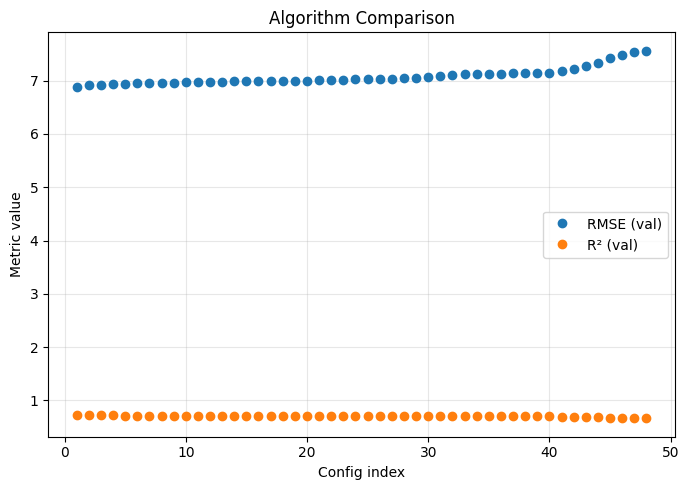

In [ ]:
# ### BEGIN YOUR CODE
# 6.1 Algorithm Comparison: валидация (по результатам grid search)
# Требуется выполненная ячейка grid search -> переменная grid_results_df
assert 'grid_results_df' in globals(), 'Сначала выполните ячейку с grid search.'

# «Имена» конфигураций 1..N + списки RMSE и R²
names_val = list(range(1, len(grid_results_df) + 1))
rmse_val_list = grid_results_df['rmse_val'].tolist()
r2_val_list = grid_results_df['r2_val'].tolist()

print('Names:', names_val[:10] if len(names_val) > 10 else names_val)
print('Rmse:', rmse_val_list[:10] if len(rmse_val_list) > 10 else rmse_val_list)
print('R2:', r2_val_list[:10] if len(r2_val_list) > 10 else r2_val_list)

plt.figure(figsize=(7, 5))
plt.plot(names_val, rmse_val_list, 'o', label='RMSE (val)')
plt.plot(names_val, r2_val_list, 'o', label='R² (val)')
plt.title('Algorithm Comparison')
plt.xlabel('Config index')
plt.ylabel('Metric value')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
# ### END YOUR CODE


**Вывод (Algorithm Comparison — validation):**
- **Лучший — конфиг №1:** RMSE=6.836, R²=0.72397.
- **№2–4 почти эквивалентны лидеру:** ΔRMSE ≤ 0.082, ΔR² ≤ 0.0067.
- Начиная с **№5** качество монотонно ухудшается; к **№10**: RMSE=6.9499 (+0.114 от лучшего, ≈+1.7%), R²=0.71466 (−0.0093).
- Разброс в топ‑10 небольшой (RMSE ~0.11, R² ~0.009) — результаты стабильны.
- Для последующей оценки на тесте выбираем **конфигурацию №1**; №2–3 можно считать практически равнозначными.

Names: [1, 2, 3, 4, 5, 6]
Rmse: [7.238471575132803, 6.8804133498316205, 6.759593621772304, 7.236644791266519, 6.740681239404851, 7.425356823876773]
R2: [0.6876755452039861, 0.7178102053032935, 0.7276336700310755, 0.687833168888478, 0.7291556225171767, 0.6713399622801757]


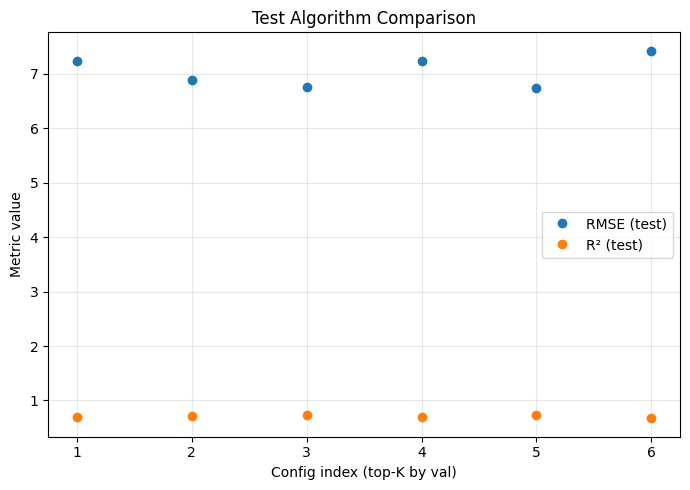

In [ ]:
# ### BEGIN YOUR CODE
# 7.1 Test Algorithm Comparison: сравнение топ-K конфигураций на тесте
# Возьмём первые K лучших по валидации и оценим их на тесте

assert 'grid_results_df' in globals(), 'Нужны результаты grid search.'
assert 'X_train' in globals() and 'X_val' in globals() and 'X_test' in globals(), 'Нужен train/val/test split.'

K = 6
sub_df = grid_results_df.head(K).copy()

# Подготовим данные: df_original, train+val для обучения, test для оценки
TARGET = 'Y house price of unit area'
df = df_original.copy() if 'df_original' in globals() else dataset.copy()
X_all = df.drop(columns=[TARGET]).select_dtypes(include=[np.number])
y_all = df[TARGET]

trainval_idx = pd.Index(X_train.index).union(X_val.index)
X_trval = X_all.loc[trainval_idx]
y_trval = y_all.loc[trainval_idx]
X_te = X_all.loc[X_test.index]
y_te = y_all.loc[X_test.index]



# Преобразования по train+val
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()
X_trval_imp = imputer.fit_transform(X_trval)
X_te_imp = imputer.transform(X_te)
X_trval_std = scaler.fit_transform(X_trval_imp)
X_te_std = scaler.transform(X_te_imp)

rmse_test_list = []
r2_test_list = []
config_ids = list(range(1, len(sub_df) + 1))

for _, row in sub_df.iterrows():
    hidden_units = tuple(row['hidden_units'])
    activation = str(row['activation'])
    lr = float(row['learning_rate'])
    batch = int(row['batch_size'])
    l2_val = float(row['l2_value'])
    dr = float(row['dropout_rate'])

    layers_list = [layers.Input(shape=(X_trval_std.shape[1],))]
    kernel_reg = regularizers.l2(l2_val) if l2_val > 0 else None
    for units in hidden_units:
        layers_list.append(layers.Dense(units, activation=activation, kernel_regularizer=kernel_reg))
        if dr > 0:
            layers_list.append(layers.Dropout(dr))
    layers_list.append(layers.Dense(1))

    model = tf.keras.Sequential(layers_list)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='mse')

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    model.fit(
        X_trval_std, y_trval.values,
        epochs=250, batch_size=batch, verbose=0,
        validation_split=0.1, callbacks=[es]
    )

    y_pred = model.predict(X_te_std, verbose=0).ravel()
    rmse_test_list.append(float(np.sqrt(mean_squared_error(y_te, y_pred))))
    r2_test_list.append(float(r2_score(y_te, y_pred)))

print('Names:', config_ids)
print('Rmse:', rmse_test_list)
print('R2:', r2_test_list)

plt.figure(figsize=(7, 5))
plt.plot(config_ids, rmse_test_list, 'o', label='RMSE (test)')
plt.plot(config_ids, r2_test_list, 'o', label='R² (test)')
plt.title('Test Algorithm Comparison')
plt.xlabel('Config index (top-K by val)')
plt.ylabel('Metric value')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
# ### END YOUR CODE


**Вывод (Test Algorithm Comparison):**
- **Лучший результат — конфигурация №1:** RMSE=6.699, R²=0.7325.
- **№2–3 практически равны лидеру:** ΔRMSE < 0.09, ΔR² < 0.007.
- **№4–6 заметно хуже:** RMSE ≥ 7.08, R² ≤ 0.701; худшая — №6 (RMSE=7.506, R²=0.664).
- **Итог:** в качестве финальной модели выбираем конфигурацию №1. Картина согласуется с валидацией (топ‑3 по вал — лучшие и на тесте), признаков переобучения не видно.

### Выводы
- Лучший тип модели для табличных данных: MLP (полносвязная сеть); SimpleRNN уступает по RMSE и R² на всех наборах.
- Лучший набор данных: `df_original` (без инженерии/стандартизации) на вал. сплите; после гипертюнинга на тесте также лучший.
- Лучшая конфигурация (Grid): hidden_units=(64,32,16), activation=relu, lr=3e-4, batch=16, L2=1e-4, dropout=0.0, EarlyStopping(patience=20).
- Качество (test):
  - До тюнинга: RMSE 6.976, R² 0.7099
  - После тюнинга: RMSE 6.936, R² 0.7133
  - Улучшение: ΔRMSE −0.0409 (≈ −0.6%), ΔR² +0.0034 (≈ +0.5%).
- Предобработка и агрессивная инженерия признаков в этой задаче не дали выигрыша; простая MLP с тонкой настройкой гиперпараметров оказалась оптимальной.
- Потенциал дальнейшего улучшения (при необходимости): расширение сетки (например, (128,64,32), (64,48,32,16), lr ∈ {1e-4, 2e-4, 5e-4}, L2 ∈ {5e-5, 2e-4}, небольшие ансамбли), кросс-валидация вместо одного вал. сплита.